# Реализация логистической регрессии в TensorFlow

In [45]:
import numpy as np
import tensorflow as tf


In [63]:
%matplotlib inline
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Генерируем данные для задачи регрессии

In [64]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000
RANDOM_STATE = 7

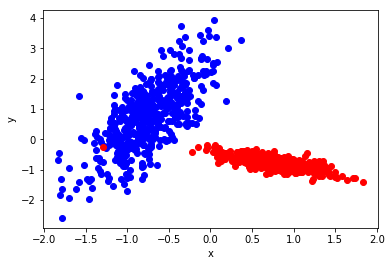

In [52]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples = NUM_SAMPLES,
    n_features = NUM_FEATURES,
    n_informative = NUM_FEATURES,
    n_redundant = 0,
    n_classes = 2,
    n_clusters_per_class = 1,
    class_sep = 0.75,
    random_state = RANDOM_STATE
)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(
    X[ones, 0], X[ones, 1], 'ob',
    X[zeros, 0], X[zeros, 1], 'or'
);

## Вспомогательная функция для создания операций

In [56]:
import random
import string

def py_func_with_grad(func, inputs, Tout, grad, name = None, stateful=False, graph=None):
    name_prefix = ''.join(random.choices(string.ascii_letters, k = 10))
    name = '{}_{}'.format(name_prefix, name or '')
    grad_func_name = '{}_grad'.format(name)
    tf.RegisterGradient(grad_func_name)(grad)
    graph = graph or tf.get_default_graph()
    
    with graph.gradient_override_map({
        'PyFunc': grad_func_name, 
        'PyFuncStateless': grad_func_name
    }):
        with tf.name_scope(name, 'PyFuncOp', inputs):
            return tf.py_func(func, inputs, Tout, stateful=stateful, name=name)

## Реализация линейной опреаций

In [57]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T)  # аргументы являются numpy-массивами


def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(
        tf.multiply(X, grads),
        axis=0,
        keep_dims=True
    )
    return dX, dW


class Sigmoid(object):
    @staticmethod
    @np.vectorize
    def np_output(x):
        return (1 / (1 + np.exp(-x))).astype(np.float32)
    
    @staticmethod
    def tf_output(x, name=None):
        with tf.name_scope(name, "sigmoid", [x]) as name:
            y = tf.py_func(Sigmoid.np_output, [x], [tf.float32], name=name, stateful=False)
            return y[0]    
    
    @staticmethod    
    def tf_derivate(x):
        output = Sigmoid.tf_output(x)
        return output * (1 - output) 

    
def sigmoid_op_forward(X):
    return Sigmoid.np_output(X) 


def sigmoid_op_backward(op, grads):
    X = op.inputs[0]
    dX = tf.multiply(grads, Sigmoid.tf_derivate(X))
    return dX

## Создание графа вычислений и обучение модели

In [60]:
BATCH_SIZE = NUM_SAMPLES // 10
EPOCH_COUNT = 25

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype=tf.float32, shape=[None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype=tf.float32, shape=[None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(
        shape=[1, NUM_FEATURES],
        dtype=tf.float32,
        seed=RANDOM_STATE
    ))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(
        linear_op_forward,         # функция предсказания модели 
        [plh_X, var_W],            # аргументы функции
        [tf.float32],              # тип выходных значений
        name='linear_op',        # имя операции 
        grad=linear_op_backward, # функция для вычисления градиента
        graph=sess.graph         # объект графа вчислений
    )       
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(
        sigmoid_op_forward,
        [var_Pred],
        [tf.float32],
        name='sigmoid_op',
        grad=sigmoid_op_backward,
        graph=sess.graph
    )
    
    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.9).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    # массив индексов объектов
    indices = np.arange(len(X))  
    
    # выполняем итерации по 10-ти эпохам
    for epoch in range(EPOCH_COUNT):
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run(
                [cost, optimizer],  # указываем, какие операции необходимо выполнить
                feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                plh_labels: y[batch_indices]
            })
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 10 == 0:
                print('[{:03d}] loss={:.3f} weights={}'.format(steps, loss, var_W.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()

[000] loss=0.717 weights=[[0.40603805 0.5755159 ]]
[010] loss=0.575 weights=[[-0.29782063  1.1644907 ]]
[020] loss=0.561 weights=[[-0.7629573  1.5001963]]
[030] loss=0.563 weights=[[-1.1077571  1.7020142]]
[040] loss=0.546 weights=[[-1.3817952  1.8394064]]
[050] loss=0.570 weights=[[-1.6104679  1.947912 ]]
[060] loss=0.528 weights=[[-1.8063273  2.0252044]]
[070] loss=0.534 weights=[[-1.986801   2.0835173]]
[080] loss=0.557 weights=[[-2.1472607  2.1323738]]
[090] loss=0.556 weights=[[-2.291577   2.1730998]]
[100] loss=0.549 weights=[[-2.426867   2.2042608]]
[110] loss=0.550 weights=[[-2.5439475  2.2416823]]
[120] loss=0.522 weights=[[-2.658955   2.2664063]]
[130] loss=0.533 weights=[[-2.7647953  2.2868938]]
[140] loss=0.563 weights=[[-2.8673413  2.3068018]]
[150] loss=0.536 weights=[[-2.9656758  2.3203132]]
[160] loss=0.536 weights=[[-3.0503638  2.3416302]]
[170] loss=0.529 weights=[[-3.1359043  2.3564878]]
[180] loss=0.517 weights=[[-3.2131307  2.374301 ]]
[190] loss=0.492 weights=[[-3

## Визуализируем кривую обучения

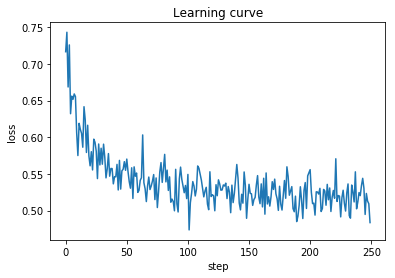

In [61]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

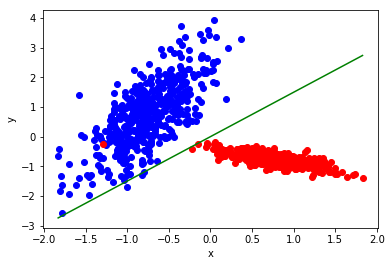

In [62]:
y_pred = - X[:, 0] * weights[0, 0] / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');